The project has been done on Google Collaboratory



In [2]:
!apt install imagemagick #For the ANIMATION part

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.8).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


Importing  libraries

In [0]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

Here we are creating Reward and Transition Matrix to then pass to our Q-fn.

In [0]:
def create_reward_matrix(grid, reward, small_penalty, large_penalty):  
    row, col = np.shape(grid)
    states = row*col  
    
    walls = (1 - grid)*large_penalty
    path = grid*small_penalty
    
    combined = path + walls
    combined[-1, -1] = reward           
    reward_matrix = np.reshape(combined, states)
    return reward_matrix

In [0]:
def create_transition_matrix(grid, large_penalty, prob, reward_matrix):
    row, col = np.shape(grid)
    states = row*col
    p = prob
    q = (1 - prob)*0.5
    
    val_up = np.zeros((states, states))
    val_left = np.zeros((states, states))
    val_right = np.zeros((states, states))
    val_down = np.zeros((states, states))
    
    wall_ind = np.where(reward_matrix == large_penalty)[0]

    for i in range(states):
        # Up
        if (i - col) < 0 or (i - col) in wall_ind :
            val_up[i, i] += p
        else:
            val_up[i, i - col] += p
        
        if i%col == 0 or (i - 1) in wall_ind:
            val_up[i, i] += q
        else:
            val_up[i, i-1] += q
        
        if i%col == (col - 1) or (i + 1) in wall_ind:
            val_up[i, i] += q
        else:
            val_up[i, i+1] += q
            
        # Down
        if (i + col) > (states - 1) or (i + col) in wall_ind:
            val_down[i, i] += p
        else:
            val_down[i, i + col] += p
        
        if i%col == 0 or (i - 1) in wall_ind:
            val_down[i, i] += q
        else:
            val_down[i, i-1] += q
        
        if i%col == (col - 1) or (i + 1) in wall_ind:
            val_down[i, i] += q
        else:
            val_down[i, i+1] += q
            
        # Left
        if i%col == 0 or (i - 1) in wall_ind:
            val_left[i, i] += p
        else:
            val_left[i, i-1] += p
            
        if (i - col) < 0 or (i - col) in wall_ind:
            val_left[i, i] += q
        else:
            val_left[i, i - col] += q
        
        if (i + col) > (states - 1) or (i + col) in wall_ind:
            val_left[i, i] += q
        else:
            val_left[i, i + col] += q
        
        # Right
        if i%col == (col - 1) or (i + 1) in wall_ind:
            val_right[i, i] += p
        else:
            val_right[i, i+1] += p
            
        if (i - col) < 0 or (i - col) in wall_ind:
            val_right[i, i] += q
        else:
            val_right[i, i - col] += q
        
        if (i + col) > (states - 1) or (i + col) in wall_ind:
            val_right[i, i] += q
        else:
            val_right[i, i + col] += q
    
    transition_matrix = [val_up, val_left, val_right, val_down] 
    
    return transition_matrix


In [0]:
def computeDimensions(transition):
    A = len(transition)
    try:
        if transition.ndim == 3:
            S = transition.shape[1]
        else:
            S = transition[0].shape[0]
    except AttributeError:
        S = transition[0].shape[0]
    return S, A

This is our Q-learning class where the actual Q values are determined.

In [0]:
class QLearning():

    def __init__(self, transitions, reward, discount, alpha, epsilon = 0.5, 
                 decay = 1.0, n_iter = 50000):

        self.max_iter = int(n_iter)
        self.S, self.A = computeDimensions(transitions)
        self.P = tuple(transitions[a] for a in range(self.A))

        self.epsilon = epsilon
        self.decay = decay

        self.R = reward
        self.discount = discount
        self.alpha = alpha


        # Initialisations
        self.Q = np.zeros((self.S, self.A))
        self.mean_diff = []

    def Qfunc(self):
        # Run the Q-learning algoritm.
        diff = []

        # initial state choice
        s = 0 # np.random.randint(0, self.S)

        for n in range(1, self.max_iter + 1):

            # Reinitialisation of trajectories every 100 transitions
            if (n % 100) == 0:
                s = np.random.randint(0, self.S)

            # Action choice 
            pn = np.random.random()
            if pn < (1 - self.epsilon):
                # optimal_action = self.Q[s, :].max()
                a = self.Q[s, :].argmax()
            else:
                a = np.random.randint(0, self.A)
            
            self.epsilon *= self.decay
            
            # Simulating next state newstate and reward associated to <s,newstate,a>
            p_newstate = np.random.random()
            p = 0
            newstate = -1
            while (p < p_newstate) and (newstate < (self.S - 1)):
                newstate = newstate + 1
                p = p + self.P[a][s, newstate]

            try:
                r = self.R[a][s, newstate]
            except IndexError:
                try:
                    r = self.R[s, a]
                except IndexError:
                    r = self.R[s]

            # Updating the value of Q
            # Decaying update coefficient (1/sqrt(n+2)) can be changed
            qval = r + self.discount * self.Q[newstate, :].max() - self.Q[s, a]

            nqval = self.alpha * qval
            self.Q[s, a] = self.Q[s, a] + nqval

            # current state is updated
            s = newstate
            
            # Computing and saving maximal values of the Q variation
            diff.append(np.absolute(nqval))

            # Computing means all over maximal Q variations values
            if len(diff) == 1000:
                self.mean_diff.append(np.mean(diff))
                diff = []

            # compute the value function and the policy
            self.V = self.Q.max(axis=1)
            self.policy = self.Q.argmax(axis=1)
        
        self.V = tuple(self.V.tolist())
        try:
            self.policy = tuple(self.policy.tolist())
        except AttributeError:
            self.policy = tuple(self.policy)

In [188]:
grid =  np.array([
    [ 1.,  0.,  1.,  0.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  0.],
    [ 1.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  0.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]]) 
    
reward_matrix = create_reward_matrix(grid, 1, -0.04, -0.75)
transition_matrix = create_transition_matrix(grid, -0.75,  0.8, reward_matrix)

print("Reward Matrix: \n", np.reshape(np.array(list(reward_matrix)), np.shape(grid)))
print("\nTransition Matrix:\n", transition_matrix)


Reward Matrix: 
 [[-0.04 -0.75 -0.04 -0.75 -0.75 -0.04 -0.04]
 [-0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.75]
 [-0.04 -0.75 -0.75 -0.04 -0.04 -0.04 -0.75]
 [-0.04 -0.04 -0.04 -0.04 -0.75 -0.04 -0.04]
 [-0.04 -0.75 -0.04 -0.75 -0.04 -0.04 -0.04]
 [-0.04 -0.75 -0.04 -0.04 -0.04 -0.75 -0.75]
 [-0.04 -0.04 -0.04 -0.75 -0.04 -0.04  1.  ]]

Transition Matrix:
 [array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.1, 0.8, 0.1, ..., 0. , 0. , 0. ],
       [0. , 0. , 1. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.1, 0.1, 0. ],
       [0. , 0. , 0. , ..., 0.1, 0.8, 0.1],
       [0. , 0. , 0. , ..., 0. , 0.1, 0.9]]), array([[0.9, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.8, 0.1, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.9, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.9, 0. , 0. ],
       [0. , 0. , 0. , ..., 0.8, 0.2, 0. ],
       [0. , 0. , 0. , ..., 0. , 0.8, 0.2]]), array([[0.9, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.1, 0.8, ..., 0. , 0. , 0. ],
 

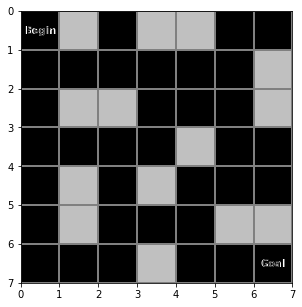

In [189]:

## grid diagram

import matplotlib.pyplot as plt
from matplotlib import colors
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
ax.text(0.5, 0.5, 'Begin', ha='center', va='center',color='white',fontweight='bold')
ax.text(6.5, 6.5, 'Goal', ha='center', va='center',color='white',fontweight='bold')
cmap = colors.ListedColormap(['silver', 'black'])
ax.pcolormesh(grid, cmap = cmap, zorder=1)
ax.grid(True, color="grey", lw=2)
ax.text(0.5, 0.5, 'Begin', ha='center', va='center')
ax.text(6.5, 6.5, 'Goal', ha='center', va='center')
plt.axes().set_aspect('equal') 
plt.axes().invert_yaxis()
plt.show()

In [0]:
gamma = 0.9 
alpha = 0.3 
eps = 0.5 
decay = 1.0 

def get_path(iters):
  np.random.seed(1)
  q = QLearning(transition_matrix, reward_matrix, gamma, alpha, eps, decay, iters)
  q.Qfunc()

  pol = np.reshape(np.array(list(q.policy)), np.shape(grid))
  return get_path_from_policy(pol)

def get_path_from_policy(pol):
  print (pol)
  path = [[0,0]]
  i = 0
  j = 0
  while (i != np.shape(grid)[0] - 1 or j != np.shape(grid)[1] - 1):
    if pol[i][j] == 3:
      i += 1
    elif pol[i][j] == 2:
      j += 1
    elif pol[i][j] == 1:
      j -= 1
    elif pol[i][j] == 0:
      i -= 1
    path.append([i,j])
  return path



Through this func we get the optimal path(q learnng is called through it)

In [191]:
path = get_path(50000)



[[3 1 3 1 3 3 1]
 [3 1 2 2 2 3 1]
 [3 1 2 2 2 3 3]
 [2 2 3 1 2 3 1]
 [0 2 3 2 3 1 1]
 [3 2 2 2 3 0 3]
 [2 2 0 0 2 2 2]]


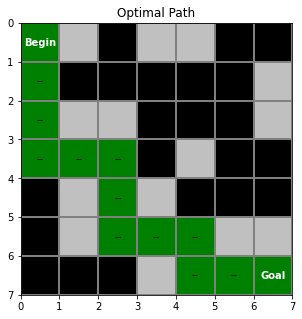

In [192]:
## Optimal Path diagram 

import matplotlib.pyplot as plt
from matplotlib import colors
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

path_grid = grid.copy()
for idx in path:
  c,r = idx[0], idx[1]
  path_grid [c, r] = 2
  ax.text(r+0.5, c+0.5, '--', ha='center', va='center')

cmap = colors.ListedColormap(['silver', 'black', 'green'])
ax.pcolormesh(path_grid, cmap = cmap, zorder=1)
ax.grid(True, color="grey", lw=2)
ax.text(0.5, 0.5, 'Begin', ha='center', va='center',color='white',fontweight='bold')
ax.text(6.5, 6.5, 'Goal', ha='center', va='center',color='white',fontweight='bold')

plt.axes().set_aspect('equal') 
plt.axes().invert_yaxis()
plt.title("Optimal Path")
plt.show()

#Please open Created GIF called as animation.gif after running this, if on collabratory

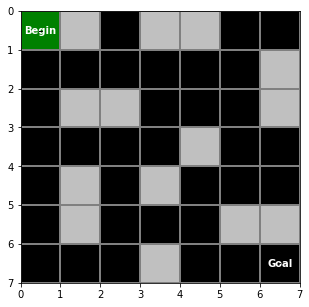

In [193]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.text(0.5, 0.5, 'Begin', ha='center', va='center',color='white',fontweight='bold')
ax.text(6.5, 6.5, 'Goal', ha='center', va='center',color='white',fontweight='bold')


def step(i):
  path_grid = grid.copy()
  for idx in path[0:i+1]:
    c,r = idx[0], idx[1]
    path_grid [c, r] = 2
    ax.text(r+0.5, c+0.5, '-', ha='center', va='center')
  cmap = colors.ListedColormap(['silver', 'black', 'green'])
  ax.pcolormesh(path_grid, cmap = cmap, zorder=1)
  ax.grid(True, color="grey", lw=2)
  return ax


anim = FuncAnimation(fig, step, frames=np.arange(0, len(path)), interval=200)

plt.axes().invert_yaxis()
anim.save('animation.gif', dpi=80, writer='imagemagick')
#plt.show() 